In [63]:
#fix values in the HOSTLIBS!
#MAGERR>0.,5 should work -> MAG = 99 +_ 9
import glob
import pandas as pd 
import GCRCatalogs
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import astropy.units as u
import time

In [64]:
sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [65]:
fns = glob.glob("/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/magerr/unzip/*HOSTLIB")
fns = [fn for fn in fns if "header" not in fn]

In [66]:
fns[0]

'/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/magerr/unzip/UNMATCHED_COSMODC2_GHOST.HOSTLIB'

In [82]:
newDF['SQRADIUS'].values

array([246.0011,  15.2351,  25.5603, ...,  40.4571,   4.3767,  11.9332])

In [ ]:
from astropy.cosmology import FlatLambdaCDM

cosmology = FlatLambdaCDM(H0=70, Om0=0.3)

#0 for bulge, 1 for disk
for fn in fns:
    tempDF = pd.read_csv(fn, delim_whitespace=True)
    gid = tempDF['GALID'].values

    cosmo = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4")
    print("Loaded cosmoDC2 catalog")

    features = np.array(['redshift_true', 'size_disk_true', 'size_minor_disk_true', 'size_bulge_true',
                     'size_minor_bulge_true','galaxy_id'])

    filters=[(lambda x: np.isin(x, gid), 'galaxy_id')]
    cdc2_true = {}
    for feature in features:
        cdc2_true[feature] = []
    c = 0
    print(cdc2_true.keys())
    start_time = time.time()
    for gal in cosmo.get_quantities(features, filters=filters, return_iterator=True):
        for feature in features:
           cdc2_true[feature].append(gal[feature])
        elapsed = time.time() - start_time
        print(c, "Elapsed time = ", elapsed)
        c+=1
    for feature in features:
        cdc2_true[feature] = np.concatenate(cdc2_true[feature])

    cdc2_true = pd.DataFrame(cdc2_true)
    cdc2_true.rename(columns={'galaxy_id':'GALID', 'size_disk_true':'a1', 'size_bulge_true':'a0', 'size_minor_disk_true':'b1', 'size_minor_bulge_true':'b0'}, inplace=True)
    cdc2_true['dist_pc_old'] = cosmology.luminosity_distance(cdc2_true['redshift_true'].values).to(u.pc).value
    newDF = pd.merge(cdc2_true, tempDF, on=['GALID'], how='left')
    newDF['dist_pc_new'] = cosmology.luminosity_distance(newDF['ZTRUE'].values).to(u.pc).value
    for param in np.array(['a0', 'a1', 'b0', 'b1']):
        newDF[param + "_pc"] = newDF[param]*newDF['dist_pc_old']/206265
        newDF[param + "_new"] = newDF[param + "_pc"]*206265/newDF['dist_pc_new']
        scaleFac =  newDF[param + "_new"].values**2/ newDF[param].values**2
        plt.figure(figsize=(10,7))
        plt.plot(newDF[param], newDF[param + "_new"], 'o', ms=0.05)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel(param + " old")
        plt.ylabel(param + " new")
        plt.savefig("%s_%s.png"%(param, fn.split("/")[-1]), dpi=200, bbox_inches="tight")
        del newDF[param]
        del newDF[param + "_pc"]
        newDF[param] = newDF[param + "_new"]
    newDF['SQRADIUS_new'] = newDF['SQRADIUS']*scaleFac 
    newDF.to_csv(fn + "_shift", sep=' ')

Loaded cosmoDC2 catalog
dict_keys(['redshift_true', 'size_disk_true', 'size_minor_disk_true', 'size_bulge_true', 'size_minor_bulge_true', 'galaxy_id'])
0 Elapsed time =  0.3250541687011719
1 Elapsed time =  1.8244969844818115
2 Elapsed time =  3.0484578609466553
3 Elapsed time =  4.568279266357422
4 Elapsed time =  6.172702312469482
5 Elapsed time =  7.585074424743652
6 Elapsed time =  8.946159601211548
7 Elapsed time =  10.360630989074707
8 Elapsed time =  11.557509183883667
9 Elapsed time =  12.9490807056427
10 Elapsed time =  14.150436162948608
11 Elapsed time =  15.368553876876831
12 Elapsed time =  16.592479705810547
13 Elapsed time =  18.08595895767212
14 Elapsed time =  19.26907181739807
15 Elapsed time =  20.34907364845276
16 Elapsed time =  21.90633535385132
17 Elapsed time =  23.420616149902344
18 Elapsed time =  25.004677772521973
19 Elapsed time =  26.531962156295776
20 Elapsed time =  27.948459148406982
21 Elapsed time =  29.232757091522217
22 Elapsed time =  30.6808156967

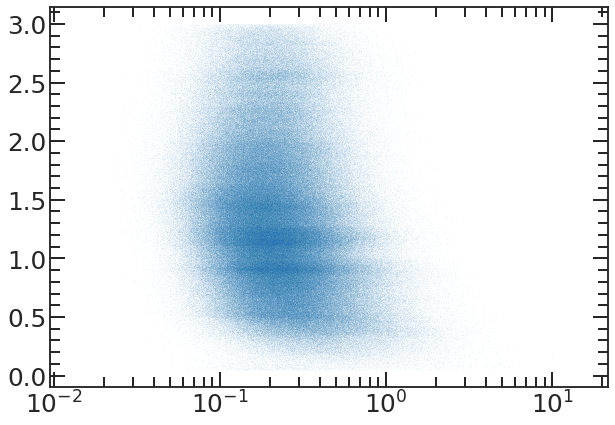

In [76]:
plt.figure(figsize=(10, 7))
plt.plot(tempDF['a0_Sersic'], tempDF['ZTRUE'], 'o', ms=0.01)
plt.xscale("log")

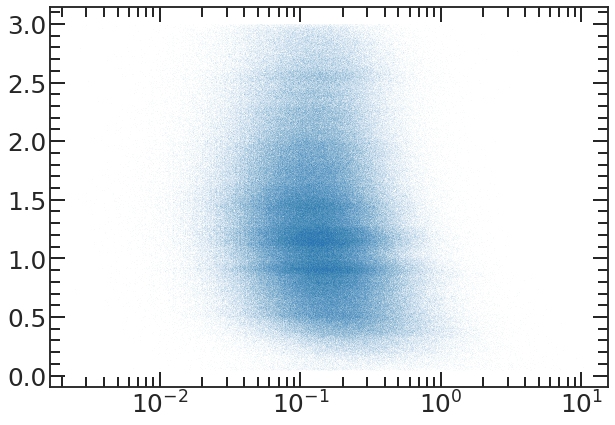

In [79]:
plt.figure(figsize=(10, 7))
plt.plot(tempDF['b0_Sersic'], tempDF['ZTRUE'], 'o', ms=0.01)
plt.xscale("log")

In [51]:
cdc2_true = pd.DataFrame(cdc2_true)
cdc2_true.rename(columns={'galaxy_id':'GALID', 'size_disk_true':'a1', 'size_bulge_true':'a0', 'size_minor_disk_true':'b1', 'size_minor_bulge_true':'b0'}, inplace=True)
cdc2_true['dist_pc_old'] = cosmology.luminosity_distance(cdc2_true['redshift_true'].values).to(u.pc).value
newDF = pd.merge(cdc2_true, tempDF, on=['GALID'], how='left')
newDF['dist_pc_new'] = cosmology.luminosity_distance(newDF['ZTRUE'].values).to(u.pc).value
for param in np.array(['a0', 'a1', 'b0', 'b1']):
    newDF[param + "_pc"] = newDF[param]*newDF['dist_pc_old']/206265
    newDF[param + "_new"] = newDF[param + "_pc"]*206265/newDF['dist_pc_new']

Text(0, 0.5, 'a1_new')

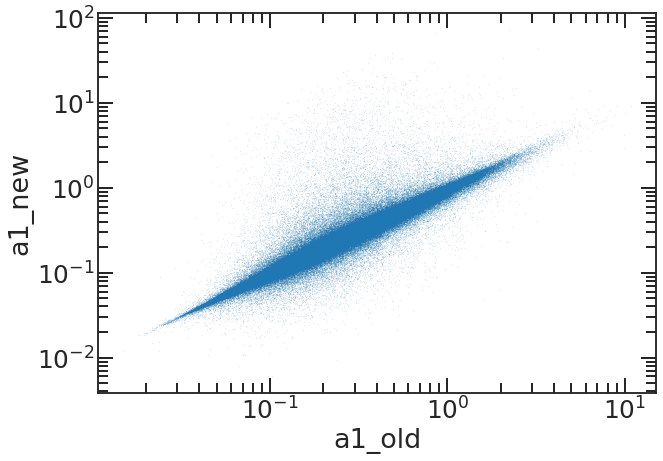

In [58]:
plt.figure(figsize=(10,7))
plt.plot(newDF['a1'], newDF['a1_new'], 'o', ms=0.05)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("a1_old")
plt.ylabel("a1_new")

Text(0, 0.5, 'Old z')

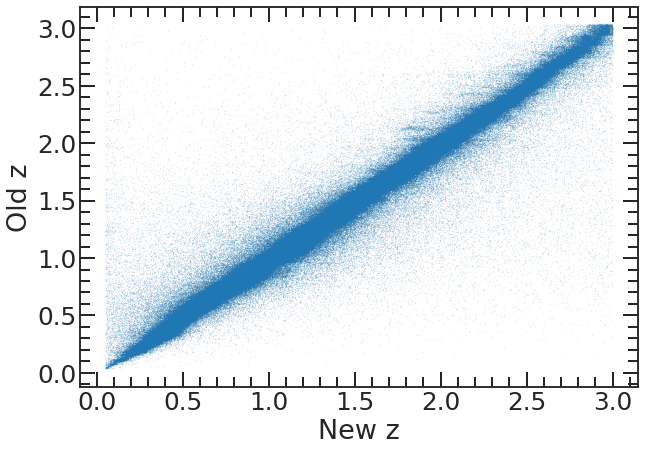

In [59]:
plt.figure(figsize=(10,7))

plt.plot(newDF['ZTRUE'].values, newDF['redshift_true'].values, 'o', ms=0.05)
plt.xlabel("New z")
plt.ylabel("Old z")

Text(0, 0.5, 'New a0 - Old a0')

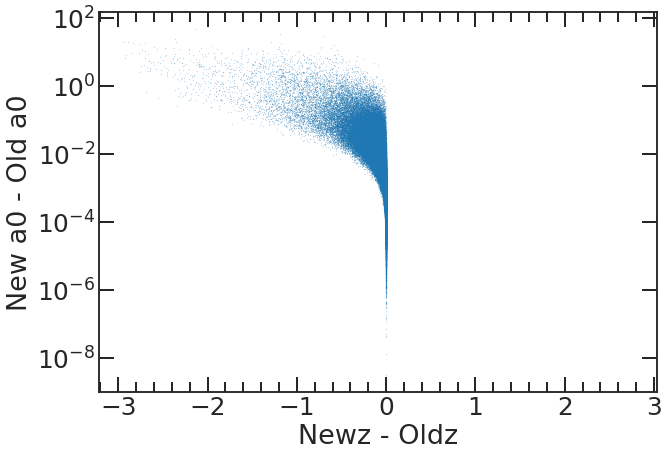

In [61]:
plt.figure(figsize=(10,7))
plt.plot(newDF['ZTRUE'].values - newDF['redshift_true'].values, newDF['a0_new'] - newDF['a0'], 'o', ms=0.1);
plt.yscale("log")
plt.xlabel("Newz - Oldz")
plt.ylabel("New a0 - Old a0")